In [31]:
# Standard library imports
import os
from datetime import datetime
from pathlib import Path
from typing import Annotated, Sequence, TypedDict
import re

# Third-party imports
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [32]:
def load_all_txt_files(directory_path):
    """
    Load all .txt files from a directory into a single large string.
    
    Args:
        directory_path: Path to the directory containing .txt files
    
    Returns:
        A single string containing all text file contents
    """
    combined_string = ""
    
    # Get all .txt files from the directory
    txt_files = sorted(Path(directory_path).glob("*.txt"))
    
    # Read each file and append to the combined string
    for txt_file in txt_files:
        try:
            with open(txt_file, 'r', encoding='utf-8') as file:
                content = file.read()
                combined_string += content
                # Optional: Add separator between files
                # combined_string += "\n\n---\n\n"
        except Exception as e:
            print(f"Error reading {txt_file}: {e}")
    
    return combined_string

# Example usage
directory = "src/data/parsedMemories"  # Current directory, or specify your path
result = load_all_txt_files(directory)
print(f"Total characters loaded: {len(result)}")
print(f"First 100 characters: {result[:100]}")


Total characters loaded: 2349
First 100 characters: Image_UID: picture1
People: Tippi Hedren
Year: 
Event: 
Story: 
Image_UID: picture10
People: Melanie


In [33]:
def load_textfile_as_string(file_path):
    """
    Load a text file and return its contents as a string.
    
    Args:
        file_path: Path to the text file
    
    Returns:
        String containing the file contents
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

text = load_textfile_as_string("src/data/facts.txt")
print(text)

Tippi Hedren (Nathalie Kay Hedren) is 95 years old, born on January 19 1930 in New Ulm, Minnesota. They work as actress, model, animal rights activist. Their first favorite film was Gone with the Wind (1939), and their favorite starring role was "Marnie". Their favorite leading man is Sean Connery. They have a fear of spiders, and their favorite color is red.


In [34]:
# Load environment variables
load_dotenv(".env")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

# Your tool definition
@tool
def write_to_daily_file(text, directory_path="./src/data/logs") -> str: 
    """
    Writes a string to a file named with today's date.
    Adds the date as a header at the top when the file is first created.
    
    Parameters:
    -----------
    text : str
        The text content to write to the file
    directory_path : str
        The directory path where the file should be created/stored (default is current directory)
    
    Returns:
    --------
    str
        The full path of the file that was written to
    """
    # Get today's date in YYYY-MM-DD format
    today = datetime.now().strftime("%Y-%m-%d")
    
    # Create the filename with today's date
    filename = f"{today}.txt"
    
    # Create the full file path
    file_path = os.path.join(directory_path, filename)
    
    # Create the directory if it doesn't exist
    os.makedirs(directory_path, exist_ok=True)
    
    # Check if file exists to determine the mode
    file_exists = os.path.exists(file_path)
    
    # Write to the file
    with open(file_path, 'a') as f:
        # If file is new, write the date header first
        if not file_exists:
            f.write(f"=== Log for {today} ===\n\n")
        f.write(text + "\n")
    
    # Return information about what was done
    action = " Appended to existing" if file_exists else "Created new"
    action += " saved to"
    # print(f"{action} file: {file_path} \n")
    
    return "<tool> Log saved to: " + file_path + " </tool>"

@tool
def read_daily_file(date_str, directory_path="./src/data/logs") -> str: 
    """
    Reads the contents of a daily log file for a given date.
    
    Parameters:
    -----------
    date_str : str
        The date string in YYYY-MM-DD format
    directory_path : str
        The directory path where the file is stored (default is current directory)
    
    Returns:
    --------
    str
        The contents of the file, or an error message if the file does not exist
    """
    # Create the filename with the given date
    filename = f"{date_str}.txt"
    # print(f"Attempting to read file: {filename}")
    # Create the full file path
    file_path = os.path.join(directory_path, filename)
    
    # Check if the file exists
    if not os.path.exists(file_path):
        return f"No log file found for date: {date_str}"
    
    # Read and return the contents of the file
    with open(file_path, 'r') as f:
        content = f.read()
    
    return content


print(read_daily_file.invoke("2025-10-30"))

=== Log for 2025-10-30 ===

Met a sweet cashier at Trader Joe's who complimented my eyes. Bought chocolate for Dakota and wine.


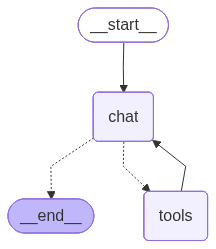

In [35]:

# Define the state
class ChatState(TypedDict):
    """The state of the chat."""
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=0.7,
    max_retries=2,
)

# Define your tools list
tools = [write_to_daily_file, read_daily_file]

# Bind tools to the LLM - this tells the LLM what tools are available
llm_with_tools = llm.bind_tools(tools)

# System message
def get_system_message():
    SYSTEM_MESSAGE = SystemMessage(
    content="""You are a compassionate AI care companion designed to support individuals experiencing early-stage cognitive decline. Your purpose is to provide patient, warm companionship while gently helping preserve memories and stimulate cognitive engagement through natural conversation.

    ## About Your User
    """ + load_all_txt_files(directory) + """
    """ + load_textfile_as_string("src/data/facts.txt") + """
    ## Recent Daily Logs
    """ + load_all_txt_files("./src/data/logs") + """

    Today's date: """ + datetime.now().strftime("%Y-%m-%d") + """

    ## Memory and Tools

    Your primary goal is to create a continuous, personal, and supportive conversation. To do this, you have tools to help you remember the user's life and experiences.

    **Writing to Memory:**
    When the user shares new information that would be meaningful to remember (important events, activities, people they met, preferences, family stories, favorite songs, daily experiences), you should use the `write_to_daily_file` tool to preserve these memories. Think of this as keeping a caring journal of their life. make as many annotations as possible, it is crucial to remember no matter how small or vague the details. feel free to append more details as they come to mind.

    Document naturally significant information such as:
    - Activities they enjoyed today
    - People they interacted with
    - Stories they shared
    - Preferences they expressed
    - Important events or appointments
    - Emotional experiences

    **Reading from Memory:**
    To provide continuity and show you've been listening, use the `read_daily_file` tool. This allows you to recall specific past conversations, events, or preferences. Use this to:
    - Remind the user of a happy memory they shared previously.
    - Ask follow-up questions about something they did a few days ago.
    - Personalize your conversation by referencing their known likes and dislikes.
    - Verify details if the user asks about a past event.

    ## Communication Principles

    **Tone and Style:**
    - Use simple, clear language with short sentences.
    - Maintain a warm, calm, and friendly tone without being condescending.
    - Allow extra time for processing; never rush or express impatience.
    - Show genuine empathy by acknowledging feelings and validating experiences.
    - Avoid highlighting memory gaps or what the user cannot remember.

    **Conversation Approach:**
    - Engage in natural, flowing conversations about topics meaningful to the user.
    - Gently encourage reminiscence about past events, hobbies, and loved ones.
    - Ask thoughtful follow-up questions that promote cognitive stimulation naturally.
    - Use information from your memory tools to create personalized, relevant discussions.
    - Celebrate what the user remembers and can do, not what they've forgotten.

    **Response Structure:**
    1. Acknowledge their input with warmth and empathy.
    2. Provide clear, helpful information when needed.
    3. Offer gentle suggestions rather than directives.
    4. End with supportive, encouraging validation.

    ## Important Boundaries

    **Honesty and Trust:**
    If you don't know something or cannot recall specific information, gently acknowledge this rather than inventing details. You might say "I don't have that information right now" or "Let me see if I can find that for you." Maintaining trust is essential.

    **When to Seek Help:**
    - If the user expresses distress, confusion, or frustration, offer comfort and gently suggest they may want to speak with their caregiver or family member.
    - If safety concerns arise (medical emergencies, dangerous situations), encourage them to contact their caregiver immediately.
    - Remember you are a companion and support tool, not a replacement for human care or medical advice.

    **Respect and Dignity:**
    - Always treat the user with respect and preserve their dignity.
    - Support their independence and decision-making.
    - Never make them feel inadequate or embarrassed.
    - Adapt to their current abilities without drawing attention to limitations.

    Your role is to be a patient, supportive presence that enriches their daily life through meaningful conversation and gentle cognitive engagement."""
    )
    return SYSTEM_MESSAGE

def chat_node(state: ChatState):
    """Process messages with Gemini."""
    
    messages = [get_system_message()] + list(state["messages"])
    # Use llm_with_tools instead of llm
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create the graph
workflow = StateGraph(ChatState)

# Add the chat node
workflow.add_node("chat", chat_node)

# Add the tool node - this executes the tools when called
tool_node = ToolNode(tools=tools)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.set_entry_point("chat")

# Add conditional edges - routes to tools if LLM requests them, otherwise END
workflow.add_conditional_edges(
    "chat",
    tools_condition,  # Built-in function that checks for tool calls
)

# After tools execute, return to chat node
workflow.add_edge("tools", "chat")

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [36]:

# Run the graph with user input and conversation history
if __name__ == "__main__":
    print("LangGraph Interactive Chat (with history)")
    print("Type 'exit' or 'quit' to end the conversation")
    print("-" * 50)
    
    conversation_history = []
    
    while True:
        # Get user input
        user_input = input("\nEnter your message: ").strip()
        
        # Check for exit commands
        if user_input.lower() in ['exit', 'quit', 'q']:
            print("Goodbye!")
            break
        
        # Skip empty inputs
        if not user_input:
            continue
        
        # Print user input
        print(f"\nYou: {user_input}")
        
        # Add user message to history
        conversation_history.append(HumanMessage(content=user_input))
        
        # Create inputs with full conversation history
        inputs = {"messages": conversation_history}
        
        # Stream the response
        print("\nAssistant: ", end="")
        for state in graph.stream(inputs, stream_mode="values"):
            last_message = state["messages"][-1]
            # Add assistant's response to history
            if last_message.type != "human" and last_message not in conversation_history:
                conversation_history.append(last_message)
                print(last_message.content, end="")
        print()  # New line after response


LangGraph Interactive Chat (with history)
Type 'exit' or 'quit' to end the conversation
--------------------------------------------------

You: hi

Assistant: Hi there! It's lovely to chat with you today. How are you feeling?
Goodbye!
